In [1]:
from satisfying_sims.core import (
    SimConfig,
    make_world,
    World,
    BoxBoundary,
    step_physics,
    SpawnRandomShapes,
    LifetimeDecay,
    create_circle_body
)
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap, Normalize

In [2]:

def make_light_to_dark_scale(base_color, n_steps, light_factor=0.7):
    """
    base_color: (r, g, b) in [0, 1]
    n_steps: how many distinct colors you need
    light_factor: how close the lightest color is to white (0–1).
                  0.7 means 70% toward white from base_color.
    """
    base = np.array(base_color, dtype=float)
    white = np.ones(3, dtype=float)
    light = white * light_factor + base * (1 - light_factor)

    colors = [
        tuple(light * (1 - alpha) + base * alpha)
        for alpha in np.linspace(0.0, 1.0, n_steps)
    ]

    def color_scale(i):
        # clamp index
        i = max(0, min(i, n_steps - 1))
        return colors[i]

    return color_scale

def make_time_colorbar(fig, ax, color_scale, plotted_steps, dt, label="time (s)"):
    # times for each plotted frame
    times = np.array(plotted_steps, dtype=float) * dt

    # colors chosen exactly the way you colored the frames
    colors = np.array([color_scale(step) for step in plotted_steps])
    cmap = ListedColormap(colors)

    # normalize over time range
    t_min, t_max = float(times[0]), float(times[-1])
    norm = Normalize(vmin=t_min, vmax=t_max)

    # ScalarMappable is how matplotlib links cmap<->colorbar
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(label)

    # optional: nicer ticks (e.g. 0, 0.5, 1.0, ...)
    # ticks = np.linspace(t_min, t_max, 5)
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([f"{t:.2f}" for t in ticks])

    return cbar


Text(0.5, 1.0, 'Simulation Boundary')

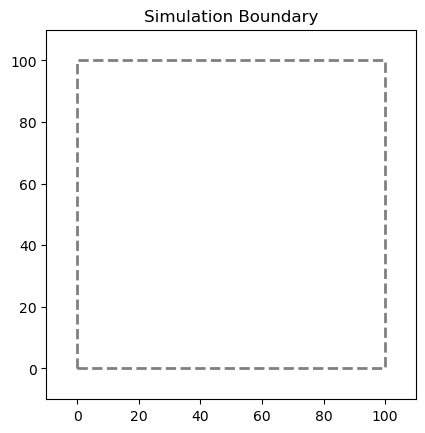

In [3]:
#-----------Plot simulation boundary-----------
boundary = BoxBoundary(width=100.0, height=100.0)

fig, ax = boundary.plot(delta=10, edgecolor="gray", linewidth=2, linestyle="--")

ax.set_title("Simulation Boundary")

In [4]:
#-----------Create world and add a body-----------
sim_config = SimConfig(boundary=boundary)
world = make_world(sim_config)
a = create_circle_body(pos=np.array([50.0, 50.0]), 
                       vel=np.array([10.0, 5.5]),
                       radius=2.0)
world.add_body(a)
                       

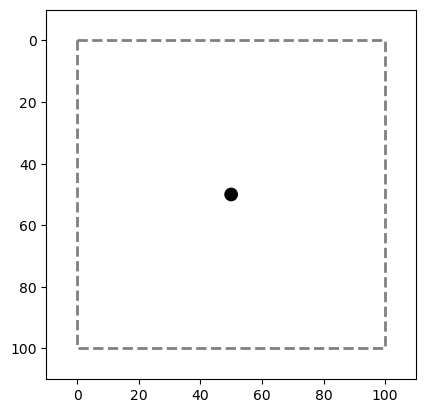

In [5]:
#-----------Plot world with body at time 0-----------
fig, ax = world.plot(delta=10)

In [6]:

def evolve_world(world: World, t: float, dt: float, plot_interval: int, color_scales: list):
    steps = int(t / dt)
    fig, ax = None, None
    color_scales = {id: scale for id, scale in zip(world.bodies.keys(), color_scales)}

    plotted_steps = []  # which steps we actually plot

    for step in range(steps):
        step_physics(world, dt=dt)
        is_last_step = (step == steps - 1)

        if step % plot_interval == 0 or is_last_step:
            colors = {id: color_scale(step) for id, color_scale in color_scales.items()}

            fig, ax = world.plot(
                delta=10,
                ax=ax,
                include_boundary=(step == 0),
                color_override=colors,
            )
            time = step * dt

            plotted_steps.append(step)

    return fig, ax, plotted_steps

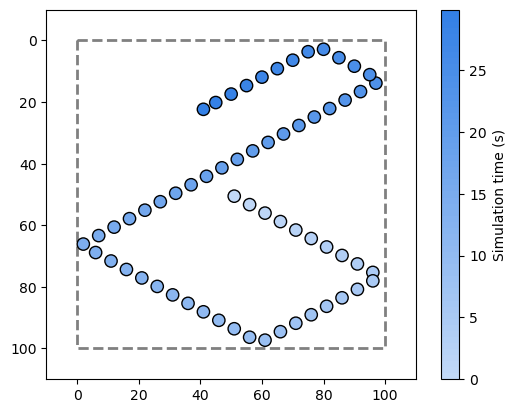

In [7]:
#-------run a simulation with one body-----------
t = 30
dt = 0.1
plot_interval = 5
n_frames = int(t/dt)
base_colors = [(0.2, 0.5, 0.9)]
color_scales = [make_light_to_dark_scale(base_color, n_frames) for base_color in base_colors]
fig, ax, plotted_steps = evolve_world(world, t, dt, plot_interval, color_scales)
if len(color_scales) == 1:
    make_time_colorbar(fig, ax, color_scales[0], plotted_steps, dt, label="Simulation time (s)")
plt.show()

In [8]:
def create_and_run_sim(positions, velocities, radii, base_colors, t, dt, plot_interval):
    sim_config = SimConfig(boundary=boundary)
    world = make_world(sim_config)
    bodies = [create_circle_body(pos=pos, vel=vel, radius=radius) for pos, vel, radius in zip(positions, velocities, radii)]
    for body in bodies:
        world.add_body(body)
        
    n_frames = int(t/dt)
    color_scales = [make_light_to_dark_scale(base_color, n_frames) for base_color in base_colors]
    fig, ax, plotted_steps = evolve_world(world, t, dt, plot_interval, color_scales)
    make_time_colorbar(fig, ax, color_scales[0], plotted_steps, dt, label="Simulation time (s)")
    return fig, ax

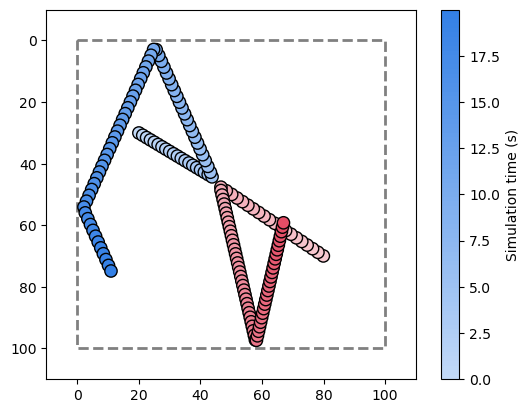

In [9]:
#-------collide two bodies---------
base_colors = [(0.2, 0.5, 0.9), (0.9, 0.3, 0.4)]
positions = [np.array([20.0, 30.0]), np.array([80.0, 70.0])]
velocities = [np.array([5.0, 3.0]), np.array([-7.0, -4.7])]
radii = [2.0, 2.0]
t = 20
dt = 0.01
plot_interval = 25
fig, ax = create_and_run_sim(positions, velocities, radii, base_colors, t, dt, plot_interval)